In [1]:
# %pip install torch torchvision albumentations==1.4.18 opencv-python-headless tifffile matplotlib

import os, glob, random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import tifffile as tiff
import cv2

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler

import albumentations as A
from albumentations.pytorch import ToTensorV2

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


c:\Users\Hassan-PC\Desktop\CV Task 3\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cpu


In [2]:
# ===================== CONFIG =====================
# --- DATA PATHS ---
IMG_DIR = r"data\images"
MSK_DIR = r"data\masks"

# --- PAIRING/IO ---
RECURSIVE     = True
IMAGE_EXTS    = {".tif", ".tiff", ".png", ".jpg", ".jpeg"}
MASK_EXTS     = {".tif", ".tiff", ".png", ".jpg", ".jpeg"}
MASK_SUFFIXES = ["", "_mask", "-mask", "_label", "-label", "_labels", "-labels"]

# --- TRANSFORMS ---
IMG_SIZE = 128
#MASK_SIZE = 128
USE_FLIPS = True
USE_COLORJITTER = False  # turn on later if pipeline is stable

# --- TRAINING ---
BATCH_SIZE   = 4
EPOCHS       = 100
BASE_CH      = 32         # try 32/64
LR_MAX       = 3e-3
WEIGHT_DECAY = 1e-4

# --- SAMPLING ---
USE_WEIGHTED_SAMPLER = True    # favor samples containing foreground
POS_SAMPLE_WEIGHT    = 3.0
NEG_SAMPLE_WEIGHT    = 1.0

VAL_FRACTION = 0.2
NUM_WORKERS  = 0               # Windows: keep 0 first
PIN_MEMORY   = False

# Checkpoint path
BEST_PATH = "best_unetmini.pth"   # saved in current folder
# ==================================================


In [3]:
import numpy as np

def ensure_3ch(img, **kwargs):
    # (H,W) -> (H,W,3), RGBA/multiband -> first 3, keep uint8
    if img.ndim == 2:
        img = np.stack([img]*3, axis=-1)
    elif img.ndim == 3:
        c = img.shape[-1]
        if c == 1:
            img = np.repeat(img, 3, axis=-1)
        elif c >= 4:
            img = img[..., :3]

    # Convert to uint8 safely
    if img.dtype != np.uint8:
        img_min, img_max = float(img.min()), float(img.max())
        if img_max <= 1.0:
            img = (img * 255.0).clip(0, 255).astype(np.uint8)
        elif img_max > 255.0:
            eps = 1e-8
            img = ((img - img_min) / (img_max - img_min + eps) * 255.0).clip(0, 255).astype(np.uint8)
        else:
            img = img.clip(0, 255).astype(np.uint8)
    return img


def read_image_any(path: str):
    p = Path(path)
    if p.suffix.lower() in (".tif", ".tiff"):
        img = tiff.imread(str(p))
    else:
        img = cv2.imread(str(p), cv2.IMREAD_UNCHANGED)
        if img is None: raise FileNotFoundError(path)
        if img.ndim == 3 and img.shape[-1] == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return ensure_3ch(img)

def read_mask_any(path: str):
    p = Path(path)
    if p.suffix.lower() in (".tif", ".tiff"):
        m = tiff.imread(str(p))
    else:
        m = cv2.imread(str(p), cv2.IMREAD_UNCHANGED)
        if m is None: raise FileNotFoundError(path)
    if m.ndim == 3:
        m = m[...,0]
    if not np.issubdtype(m.dtype, np.integer):
        m = m.astype(np.int64)
    return m


In [4]:
def list_files(root: str, exts, recursive=True):
    rootp = Path(root)
    if not rootp.exists():
        return []
    it = rootp.rglob("*") if recursive else rootp.glob("*")
    return sorted([str(p) for p in it if p.is_file() and p.suffix.lower() in exts])

def strip_mask_suffix(stem: str, suffixes):
    for sfx in suffixes:
        if sfx and stem.endswith(sfx):
            return stem[:-len(sfx)]
    return stem

class PairingDataset(Dataset):
    def __init__(self, img_dir, msk_dir, transform=None,
                 image_exts=None, mask_exts=None, mask_suffixes=None, recursive=True):
        self.transform = transform
        self.image_exts = image_exts or {".tif",".tiff",".png",".jpg",".jpeg"}
        self.mask_exts  = mask_exts  or {".tif",".tiff",".png",".jpg",".jpeg"}
        self.mask_suffixes = mask_suffixes or ["", "_mask", "-mask", "_label", "-label", "_labels", "-labels"]
        self.recursive = recursive

        imgs = list_files(img_dir, self.image_exts, recursive)
        msks = list_files(msk_dir, self.mask_exts,  recursive)

        mask_by_base = {}
        for p in msks:
            stem = Path(p).stem
            base = strip_mask_suffix(stem, self.mask_suffixes)
            mask_by_base.setdefault(base, p)

        self.pairs = []
        for ip in imgs:
            ist = Path(ip).stem
            mp = mask_by_base.get(ist)
            if mp is not None:
                self.pairs.append((ip, mp))

        if not self.pairs:
            print("[WARN] No (image,mask) pairs found. Check paths, extensions, suffixes.")

    def __len__(self): return len(self.pairs)

    def __getitem__(self, idx):
        ip, mp = self.pairs[idx]
        img = read_image_any(ip)
        msk = read_mask_any(mp)
        if self.transform:
            out = self.transform(image=img, mask=msk)
            img_t = out["image"]              # float32 CHW (after ToFloat + ToTensorV2)
            msk_t = out["mask"].long()
        else:
            img_t = torch.from_numpy(img).permute(2,0,1).float().div(255.0)
            msk_t = torch.from_numpy(msk).long()
        return img_t, msk_t


In [5]:
img_files = list_files(IMG_DIR, IMAGE_EXTS, RECURSIVE)
msk_files = list_files(MSK_DIR, MASK_EXTS,  RECURSIVE)
print("Images found:", len(img_files))
print("Masks  found:", len(msk_files))

print("\nSample images:")
for p in img_files[:5]: print(" -", p)
print("\nSample masks:")
for p in msk_files[:5]: print(" -", p)

img_stems = {Path(p).stem for p in img_files}
raw_mask_stems = {Path(p).stem for p in msk_files}
base_mask_stems = {strip_mask_suffix(s, MASK_SUFFIXES) for s in raw_mask_stems}

missing_masks  = sorted([s for s in img_stems if s not in base_mask_stems])
missing_images = sorted([strip_mask_suffix(s, MASK_SUFFIXES) for s in raw_mask_stems
                         if strip_mask_suffix(s, MASK_SUFFIXES) not in img_stems])

print("\nImages without a matching mask (by stem):", len(missing_masks))
for s in missing_masks[:20]: print(" -", s)
print("\nMasks without a matching image (by stem):", len(missing_images))
for s in missing_images[:20]: print(" -", s)


Images found: 306
Masks  found: 456

Sample images:
 - data\images\0.tif
 - data\images\1.tif
 - data\images\10.tif
 - data\images\100.tif
 - data\images\101.tif

Sample masks:
 - data\masks\0.png
 - data\masks\1.png
 - data\masks\10.png
 - data\masks\100.png
 - data\masks\100_184.png

Images without a matching mask (by stem): 0

Masks without a matching image (by stem): 150
 - 100_184
 - 101_89
 - 102_179
 - 103_225
 - 104_20
 - 105_148
 - 106_267
 - 107_59
 - 108_236
 - 109_223
 - 10_244
 - 110_287
 - 111_121
 - 112_78
 - 113_44
 - 114_220
 - 115_49
 - 116_250
 - 117_97
 - 118_125


#visualize

In [6]:
def build_train_tfms():
    aug = []
    aug.append(A.Lambda(image=ensure_3ch))
    if USE_FLIPS:
        aug += [A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.2), A.RandomRotate90(p=0.2)]
    if USE_COLORJITTER:
        aug += [A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05, p=0.5)]
    aug += [
        A.Resize(IMG_SIZE, IMG_SIZE, interpolation=cv2.INTER_LINEAR),
        A.ToFloat(max_value=255.0),  # ensures float32 [0,1]
        ToTensorV2(),
    ]
    return A.Compose(aug, additional_targets={'mask': 'mask'})

def build_val_tfms():
    return A.Compose([
        A.Lambda(image=ensure_3ch),
        A.Resize(IMG_SIZE, IMG_SIZE, interpolation=cv2.INTER_LINEAR),
        A.ToFloat(max_value=255.0),
        ToTensorV2(),
    ], additional_targets={'mask':'mask'})


In [ ]:
train_tfms = A.Compose([
    A.Lambda(image=ensure_3ch),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.10, rotate_limit=20,
                       border_mode=cv2.BORDER_REFLECT_101, p=0.7),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomBrightnessContrast(0.2, 0.2, p=0.5),
    A.GaussianBlur(blur_limit=(3,5), p=0.15),
    A.Resize(IMG_SIZE, IMG_SIZE, interpolation=cv2.INTER_LINEAR),
    A.ToFloat(max_value=255.0),
    ToTensorV2(),
], additional_targets={'mask':'mask'})


val_tfms = A.Compose([
    A.Lambda(image=ensure_3ch),
    A.Resize(IMG_SIZE, IMG_SIZE, interpolation=cv2.INTER_LINEAR),
    A.ToFloat(max_value=255.0),
    ToTensorV2(),
], additional_targets={'mask':'mask'})


In [8]:
train_tfms = build_train_tfms()
val_tfms   = build_val_tfms()

full_ds = PairingDataset(IMG_DIR, MSK_DIR, transform=train_tfms,
                         image_exts=IMAGE_EXTS, mask_exts=MASK_EXTS,
                         mask_suffixes=MASK_SUFFIXES, recursive=RECURSIVE)
print(f"Pairs found: {len(full_ds)}")

def guess_num_classes(ds, max_items=200):
    seen = set()
    k = min(len(ds), max_items)
    for i in range(k):
        _, mp = ds.pairs[i]
        m = read_mask_any(mp)
        seen.update(np.unique(m).tolist())
        if len(seen) > 32: break
    ncls = int(max(seen) + 1) if seen else 2
    print("Observed labels:", sorted(seen), "| n_classes guessed:", ncls)
    return ncls, sorted(seen)

n_classes, observed = guess_num_classes(full_ds, max_items=min(500, len(full_ds)))

# Split
n_total = len(full_ds)
n_val = max(1, int(VAL_FRACTION * n_total))
n_train = n_total - n_val
train_ds, val_ds = random_split(full_ds, [n_train, n_val],
                                generator=torch.Generator().manual_seed(SEED))

# Use deterministic val transforms (random_split shares dataset)
val_ds.dataset.transform = val_tfms

def compute_sample_weights(subset, base_ds, pos_weight=3.0, neg_weight=1.0):
    w = []
    for idx in subset.indices:
        _, mp = base_ds.pairs[idx]
        m = read_mask_any(mp)
        w.append(pos_weight if np.max(m) > 0 else neg_weight)
    return w

if USE_WEIGHTED_SAMPLER:
    tr_weights = compute_sample_weights(train_ds, full_ds, POS_SAMPLE_WEIGHT, NEG_SAMPLE_WEIGHT)
    sampler = WeightedRandomSampler(tr_weights, num_samples=len(tr_weights), replacement=True)
    train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
else:
    train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                    num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

print("Train/Val sizes:", len(train_ds), len(val_ds))


Pairs found: 306
Observed labels: [0, 1] | n_classes guessed: 2
Train/Val sizes: 245 61


In [9]:
ip, mp = full_ds.pairs[0]
x = read_image_any(ip); y = read_mask_any(mp)
print("raw:", x.shape, x.dtype, "|", y.shape, y.dtype)
z = train_tfms(image=x, mask=y)
print("after tfms:", z["image"].shape, z["image"].dtype, "|", z["mask"].shape, z["mask"].dtype)
# Expect: (3,H,W) float32 | (H,W) int64


raw: (128, 128, 3) uint8 | (128, 128) uint8
after tfms: torch.Size([3, 128, 128]) torch.float32 | torch.Size([128, 128]) torch.uint8


# Sanity check

In [10]:
def class_stats_from_dataset(base_ds, max_items=1000):
    counts = {}
    K = min(len(base_ds), max_items)
    for i in range(K):
        _, mp = base_ds.pairs[i]
        m = read_mask_any(mp)
        vs, cs = np.unique(m, return_counts=True)
        for v, c in zip(vs, cs):
            counts[int(v)] = counts.get(int(v), 0) + int(c)
    total = sum(counts.values())
    print("Class counts (approx):", counts)
    print("Total pixels counted:", total)
    return counts, total

counts, total = class_stats_from_dataset(full_ds, max_items=min(1000, len(full_ds)))

def compute_class_weights(counts, num_classes):
    weights = np.zeros(num_classes, dtype=np.float32)
    for cls in range(num_classes):
        c = counts.get(cls, 0)
        weights[cls] = 0.0 if c <= 0 else total / (num_classes * c)
    m = weights[weights>0].mean() if np.any(weights>0) else 1.0
    if m > 0: weights = weights / m  # normalize to mean ~1
    print("Class weights:", weights)
    return torch.tensor(weights, dtype=torch.float32, device=device)

class_weights = compute_class_weights(counts, n_classes)


Class counts (approx): {0: 3711232, 1: 1302272}
Total pixels counted: 5013504
Class weights: [0.51950574 1.4804944 ]


In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch, p_drop=0.15):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Dropout2d(p_drop),
            nn.Conv2d(out_ch, out_ch, 3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)


class UNetMini(nn.Module):
    def __init__(self, in_ch=3, n_classes=2, base=32):
        super().__init__()
        self.down1 = DoubleConv(in_ch, base)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(base, base*2)
        self.pool2 = nn.MaxPool2d(2)

        self.bridge = DoubleConv(base*2, base*4)

        self.up2 = nn.ConvTranspose2d(base*4, base*2, 2, stride=2)
        self.dec2 = DoubleConv(base*4, base*2)
        self.up1 = nn.ConvTranspose2d(base*2, base, 2, stride=2)
        self.dec1 = DoubleConv(base*2, base)

        self.head = nn.Conv2d(base, n_classes, 1)

    def forward(self, x):
        c1 = self.down1(x); p1 = self.pool1(c1)
        c2 = self.down2(p1); p2 = self.pool2(c2)
        b  = self.bridge(p2)
        u2 = self.up2(b);  d2 = self.dec2(torch.cat([u2, c2], dim=1))
        u1 = self.up1(d2); d1 = self.dec1(torch.cat([u1, c1], dim=1))
        return self.head(d1)

model = UNetMini(in_ch=3, n_classes=n_classes, base=BASE_CH).to(device)
print("Model params:", sum(p.numel() for p in model.parameters()))


Model params: 467842


In [12]:
ce = nn.CrossEntropyLoss(weight=class_weights if class_weights is not None else None)

def dice_loss(logits, targets, eps=1e-6):
    C = logits.shape[1]
    probs = torch.softmax(logits, dim=1)
    oh = F.one_hot(targets.clamp(min=0), C).permute(0,3,1,2).float()
    inter = (probs*oh).sum((0,2,3))
    union = probs.sum((0,2,3)) + oh.sum((0,2,3))
    dice = (2*inter + eps)/(union + eps)
    return 1.0 - dice.mean()

def total_loss(logits, targets):
    return ce(logits, targets) + 0.5*dice_loss(logits, targets)

def mean_iou(logits, targets, num_classes=None):
    preds = logits.argmax(1)
    if num_classes is None:
        num_classes = int(max(2, targets.max().item()+1))
    ious = []
    for cls in range(num_classes):
        p = (preds==cls)
        t = (targets==cls)
        inter = (p & t).sum().float()
        union = (p | t).sum().float().clamp(min=1.0)
        ious.append((inter/union).item())
    return float(np.mean(ious))


In [30]:
# --- Early stopping helper (put this right above your training loop) ---
class EarlyStopper:
    def __init__(self, patience=5, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float("inf")
        self.bad_epochs = 0

    def step(self, val_loss: float) -> bool:
        # returns True if we should stop
        if val_loss + self.min_delta < self.best:
            self.best = val_loss
            self.bad_epochs = 0
            return False
        self.bad_epochs += 1
        return self.bad_epochs >= self.patience


In [34]:
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=WEIGHT_DECAY)
steps_per_epoch = max(1, len(train_dl))
sched = torch.optim.lr_scheduler.OneCycleLR(
    opt,
    max_lr=3e-4,          # was higher; lower peak
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    pct_start=0.15,       # hit the peak earlier
    div_factor=10.0,      # initial lr = max_lr/div_factor
    final_div_factor=100  # final lr = max_lr/final_div_factor
)
history = {"tr_loss":[], "va_loss":[], "tr_mIoU":[], "va_mIoU":[],
           "tr_ce":[], "tr_dice":[], "va_ce":[], "va_dice":[]}
best_va = float("inf")
early = EarlyStopper(patience=5, min_delta=1e-4)

for epoch in range(1, EPOCHS+1):
    # ---- TRAIN ----
    model.train()
    tr_loss = tr_iou = tr_ce = tr_d = 0.0
    for imgs, msks in train_dl:
        imgs, msks = imgs.to(device), msks.to(device)
        if imgs.dtype != torch.float32: imgs = imgs.float().div_(255.0)
        logits = model(imgs)

        # split total loss for visibility
        ce_val   = ce(logits, msks)
        dice_val = dice_loss(logits, msks)
        loss     = ce_val + 0.5 * dice_val

        opt.zero_grad()
        loss.backward()
        opt.step()
        sched.step()

        tr_loss += loss.item()
        tr_iou  += mean_iou(logits.detach(), msks, n_classes)
        tr_ce   += ce_val.item()
        tr_d    += dice_val.item()

    n_tr = max(1, len(train_dl))
    tr_loss /= n_tr; tr_iou /= n_tr; tr_ce /= n_tr; tr_d /= n_tr

    # ---- VAL ----
    model.eval()
    va_loss = va_iou = va_ce = va_d = 0.0
    with torch.no_grad():
        for imgs, msks in val_dl:
            imgs, msks = imgs.to(device), msks.to(device)
            if imgs.dtype != torch.float32: imgs = imgs.float().div_(255.0)
            logits = model(imgs)
            ce_val   = ce(logits, msks)
            dice_val = dice_loss(logits, msks)
            loss     = ce_val + 0.5 * dice_val

            va_loss += loss.item()
            va_iou  += mean_iou(logits, msks, n_classes)
            va_ce   += ce_val.item()
            va_d    += dice_val.item()

    n_va = max(1, len(val_dl))
    va_loss /= n_va; va_iou /= n_va; va_ce /= n_va; va_d /= n_va

    # log
    history["tr_loss"].append(tr_loss); history["va_loss"].append(va_loss)
    history["tr_mIoU"].append(tr_iou);  history["va_mIoU"].append(va_iou)
    history["tr_ce"].append(tr_ce);     history["tr_dice"].append(tr_d)
    history["va_ce"].append(va_ce);     history["va_dice"].append(va_d)

    # checkpoint best
    if va_loss < best_va:
        best_va = va_loss
        torch.save({"model": model.state_dict(),
                    "n_classes": n_classes,
                    "base_ch": BASE_CH,
                    "img_size": IMG_SIZE}, BEST_PATH)

    print(f"epoch {epoch:02d} | "
          f"tr: CE {tr_ce:.3f} DICE {tr_d:.3f} TOT {tr_loss:.3f} mIoU {tr_iou:.3f}  ||  "
          f"va: CE {va_ce:.3f} DICE {va_d:.3f} TOT {va_loss:.3f} mIoU {va_iou:.3f}  "
          f"lr {opt.param_groups[0]['lr']:.1e}")

    # early stop check (after printing/saving)
    if early.step(va_loss):
        print("Early stopping triggered.")
        break

print(f"Best val_loss: {best_va:.4f} | saved -> {BEST_PATH}")


epoch 01 | tr: CE 0.147 DICE 0.115 TOT 0.204 mIoU 0.858  ||  va: CE 0.375 DICE 0.244 TOT 0.497 mIoU 0.682  lr 3.3e-05
epoch 02 | tr: CE 0.181 DICE 0.123 TOT 0.243 mIoU 0.847  ||  va: CE 0.379 DICE 0.219 TOT 0.488 mIoU 0.717  lr 4.2e-05
epoch 03 | tr: CE 0.135 DICE 0.107 TOT 0.189 mIoU 0.866  ||  va: CE 0.348 DICE 0.230 TOT 0.464 mIoU 0.704  lr 5.6e-05
epoch 04 | tr: CE 0.116 DICE 0.104 TOT 0.168 mIoU 0.872  ||  va: CE 0.322 DICE 0.248 TOT 0.446 mIoU 0.705  lr 7.5e-05
epoch 05 | tr: CE 0.113 DICE 0.096 TOT 0.162 mIoU 0.880  ||  va: CE 0.370 DICE 0.239 TOT 0.489 mIoU 0.689  lr 9.8e-05
epoch 06 | tr: CE 0.117 DICE 0.094 TOT 0.163 mIoU 0.884  ||  va: CE 0.348 DICE 0.204 TOT 0.450 mIoU 0.730  lr 1.2e-04
epoch 07 | tr: CE 0.110 DICE 0.088 TOT 0.155 mIoU 0.893  ||  va: CE 0.340 DICE 0.223 TOT 0.451 mIoU 0.716  lr 1.5e-04
epoch 08 | tr: CE 0.091 DICE 0.069 TOT 0.126 mIoU 0.907  ||  va: CE 0.345 DICE 0.210 TOT 0.450 mIoU 0.724  lr 1.8e-04
epoch 09 | tr: CE 0.088 DICE 0.064 TOT 0.121 mIoU 0.912 

In [27]:
# ==== MODEL SUMMARY / ARCHITECTURE PRINT ====
import torch
from torch import nn

# 1) Basic architecture + parameter counts
def count_params(m: nn.Module):
    total = sum(p.numel() for p in m.parameters())
    train = sum(p.numel() for p in m.parameters() if p.requires_grad)
    return total, train

print("=== Model Architecture ===")
print(model)  # pretty __repr__ from your UNetMini

total, trainable = count_params(model)
print(f"\nTotal params: {total:,} | Trainable: {trainable:,}")

# Optional: per-parameter table (comment out if too verbose)
print("\n=== Per-parameter breakdown (name | shape | #params | trainable) ===")
for name, p in model.named_parameters():
    print(f"{name:40s} | {tuple(p.shape)!s:20s} | {p.numel():10d} | {str(p.requires_grad)}")

# 2) Detailed layer summary (uses torchinfo if available)
try:
    from torchinfo import summary  # pip install torchinfo
    print("\n=== torchinfo.summary ===")
    summary(
        model,
        input_size=(1, 3, IMG_SIZE, IMG_SIZE),   # (B,C,H,W)
        col_names=("input_size", "output_size", "num_params", "kernel_size"),
        depth=4
    )
except Exception as e:
    print("\n[info] torchinfo not available. To install:  %pip install torchinfo")
    print("       Skipping torchinfo.summary. Error was:", repr(e))

# 3) (Optional) Forward shape trace via hooks (Conv/Pool/Up only; tidy)
def print_layer_shapes(m: nn.Module, input_size=(1,3,256,256), device=None):
    if device is None:
        device = next(m.parameters()).device
    m.eval()
    hooks = []
    def hooker(name):
        def fn(module, inputs, output):
            insh = tuple(inputs[0].shape)
            outsh = tuple(output.shape)
            print(f"{name:30s} | {insh} -> {outsh}")
        return fn

    interesting = (nn.Conv2d, nn.ConvTranspose2d, nn.MaxPool2d, nn.BatchNorm2d, nn.ReLU)
    for name, module in m.named_modules():
        if isinstance(module, interesting):
            hooks.append(module.register_forward_hook(hooker(name)))

    x = torch.zeros(input_size, device=device)
    with torch.no_grad():
        _ = m(x)

    for h in hooks: h.remove()

# Uncomment to print a concise per-layer shape trace:
# print("\n=== Forward shape trace ===")
# print_layer_shapes(model, input_size=(1,3,IMG_SIZE,IMG_SIZE), device=device)


=== Model Architecture ===
UNetMini(
  (down1): DoubleConv(
    (net): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down2): DoubleConv(
    (net): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReL

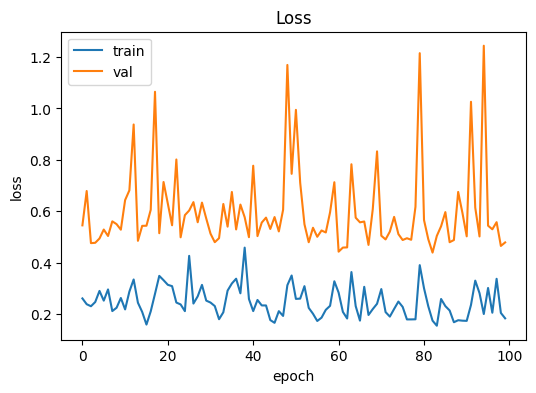

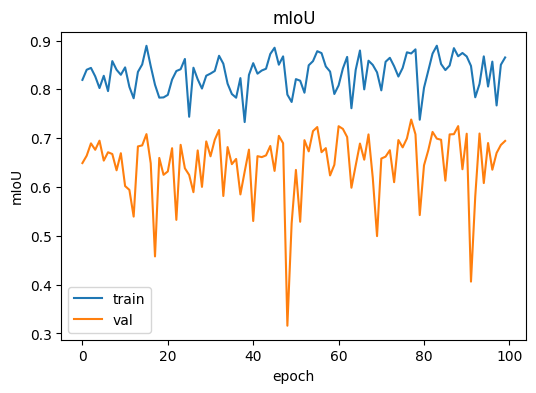

In [28]:
plt.figure(figsize=(6,4)); plt.plot(history["tr_loss"], label="train"); plt.plot(history["va_loss"], label="val")
plt.title("Loss"); plt.legend(); plt.xlabel("epoch"); plt.ylabel("loss"); plt.show()

plt.figure(figsize=(6,4)); plt.plot(history["tr_mIoU"], label="train"); plt.plot(history["va_mIoU"], label="val")
plt.title("mIoU"); plt.legend(); plt.xlabel("epoch"); plt.ylabel("mIoU"); plt.show()


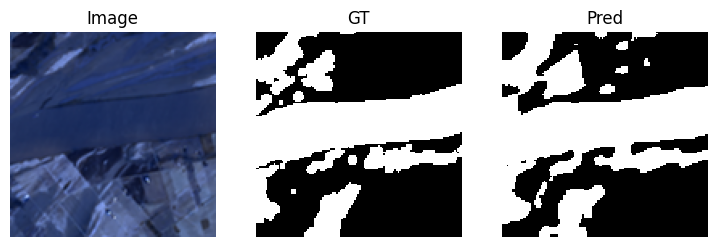

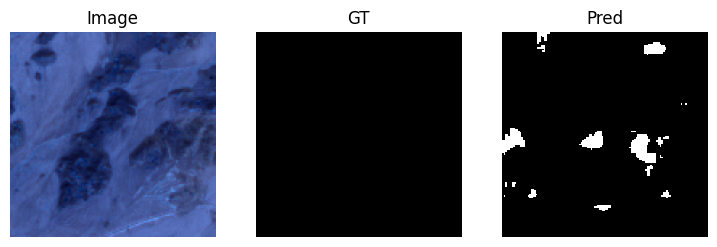

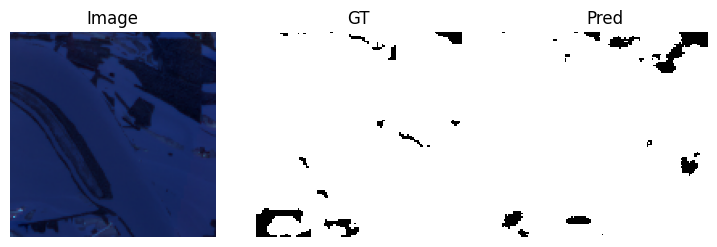

In [29]:
model.eval()
with torch.no_grad():
    imgs, msks = next(iter(val_dl))
    if imgs.dtype != torch.float32:
        imgs = imgs.float().div_(255.0)
    logits = model(imgs.to(device))
    preds = logits.argmax(1).cpu()

k = min(3, imgs.shape[0])
for i in range(k):
    plt.figure(figsize=(9,3))
    plt.subplot(1,3,1); plt.imshow(imgs[i].permute(1,2,0)); plt.title("Image"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(msks[i], cmap="gray", interpolation="nearest"); plt.title("GT"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(preds[i], cmap="gray", interpolation="nearest"); plt.title("Pred"); plt.axis("off")
    plt.show()


In [ ]:
# If first time:  %pip install flask pillow numpy opencv-python-headless torch torchvision tifffile imagecodecs --quiet

import io, threading, traceback, base64, os
from pathlib import Path
from flask import Flask, render_template, request, jsonify
from PIL import Image, ImageSequence, UnidentifiedImageError
import numpy as np, torch, cv2, tifffile

# ----- Paths (absolute) -----
CWD = Path.cwd()
TPL = CWD / "templates"
STA = CWD / "static"

# ----- Config (tweak if needed) -----
IMG_SIZE           = int(globals().get("IMG_SIZE", 512))
N_CLASSES          = int(globals().get("n_classes", 2))
FLOOD_CLASS        = int(globals().get("FLOOD_CLASS", 1))
AREA_PCT_THRESHOLD = float(os.environ.get("AREA_PCT_THRESHOLD", "0.01"))  # >=1% => FLOOD

# ----- Model selection -----
try:
    DEVICE = next(model.parameters()).device
except Exception:
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if "model" in globals() and isinstance(globals()["model"], torch.nn.Module):
    _model = globals()["model"].to(DEVICE).eval()
else:
    class _Dummy(torch.nn.Module):
        def forward(self, x):
            b,_,h,w = x.shape
            return torch.zeros((b, max(2, N_CLASSES), h, w), device=x.device)
    _model = _Dummy().to(DEVICE).eval()
    print("[WARN] No 'model' var found; using dummy (predicts NO FLOOD).")

# ----- Robust image IO -----
def ensure_hwc_uint8(arr):
    arr = np.asarray(arr)
    if arr.ndim == 3 and arr.shape[0] in (1,3,4) and arr.shape[0] < arr.shape[-1]:
        arr = np.transpose(arr, (1,2,0))  # CHW->HWC
    if arr.ndim == 2:
        arr = np.stack([arr]*3, axis=-1)
    if arr.shape[-1] > 3:
        arr = arr[..., :3]
    if arr.dtype != np.uint8:
        arr = arr.astype(np.float32)
        rng = float(arr.max() - arr.min())
        arr = np.zeros_like(arr, dtype=np.uint8) if rng <= 0 else (255.0*(arr-arr.min())/rng).clip(0,255).astype(np.uint8)
    return arr

def load_any_image(file_storage):
    file_storage.stream.seek(0)
    data = file_storage.read()
    file_storage.stream.seek(0)
    # Pillow first
    try:
        im = Image.open(io.BytesIO(data))
        try: im.seek(0)
        except: pass
        if getattr(im, "n_frames", 1) > 1:
            im = next(ImageSequence.Iterator(im))
        if im.mode in ("I;16","I;16B","I;16L","I"):
            arr8 = ensure_hwc_uint8(np.array(im, dtype=np.uint16))
            return Image.fromarray(arr8, mode="RGB")
        return im.convert("RGB")
    except Exception:
        pass
    # tifffile
    try:
        with tifffile.TiffFile(io.BytesIO(data)) as tif:
            arr = tif.asarray()
        return Image.fromarray(ensure_hwc_uint8(arr), mode="RGB")
    except Exception:
        pass
    # OpenCV
    arr = np.frombuffer(data, np.uint8)
    img = cv2.imdecode(arr, cv2.IMREAD_UNCHANGED)
    if img is not None:
        if img.ndim == 2: img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        elif img.shape[-1] == 4: img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
        else: img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return Image.fromarray(img)
    raise UnidentifiedImageError("Cannot decode image (Pillow/tifffile/OpenCV failed).")

def preprocess(pil_img, size):
    arr = np.array(pil_img)
    arr = cv2.resize(arr, (size, size), interpolation=cv2.INTER_LINEAR)
    x = torch.from_numpy(arr).permute(2,0,1).float().div(255.0).unsqueeze(0).to(DEVICE)
    return x, arr

def colorize(mask, n_classes=2):
    pal = np.array([[80,80,80],[30,180,90],[255,140,0],[200,50,50],[100,100,255],[180,30,180]], np.uint8)[:max(2,n_classes)]
    mask = np.clip(mask, 0, pal.shape[0]-1)
    return pal[mask]

# ----- Flask with explicit folders -----
app = Flask("flood_ui_final", template_folder=str(TPL), static_folder=str(STA))
app.config["MAX_CONTENT_LENGTH"] = 500 * 1024 * 1024
app.config["TEMPLATES_AUTO_RELOAD"] = True

@app.route("/debug/info")
def debug_info():
    return jsonify(
        cwd=str(CWD),
        template_folder=str(TPL),
        static_folder=str(STA),
        index_exists=(TPL / "index.html").exists(),
        css_exists=(STA / "style.css").exists(),
        device=str(DEVICE),
        img_size=int(IMG_SIZE),
        flood_class=int(FLOOD_CLASS),
        threshold=float(AREA_PCT_THRESHOLD)
    )

@app.route("/", methods=["GET"])
def home():
    return render_template("index.html",
                           device=str(DEVICE),
                           img_size=int(IMG_SIZE),
                           flood_class=int(FLOOD_CLASS),
                           threshold=float(AREA_PCT_THRESHOLD))

@app.route("/predict_json", methods=["POST"])
def predict_json():
    try:
        if "file" not in request.files: return jsonify(error="Upload under field 'file'."), 400
        f = request.files["file"]
        if f.filename == "": return jsonify(error="Empty filename."), 400

        img = load_any_image(f)
        x, base = preprocess(img, IMG_SIZE)
        with torch.no_grad():
            logits = _model.eval()(x)
            probs = torch.softmax(logits, dim=1)
            pred  = probs.argmax(1).squeeze(0).detach().cpu().numpy().astype(np.int32)
            mean_flood_prob = float(probs[0, FLOOD_CLASS].mean().item()) if FLOOD_CLASS < probs.shape[1] else None

        flood_area_px = int((pred == FLOOD_CLASS).sum())
        total_px = int(pred.size)
        area_pct = flood_area_px / max(1, total_px)
        decision = "FLOOD" if area_pct >= AREA_PCT_THRESHOLD else "NO FLOOD"

        overlay = (0.6*base + 0.4*colorize(pred, N_CLASSES)).astype(np.uint8)
        out = Image.fromarray(overlay)
        buf = io.BytesIO(); out.save(buf, format="PNG"); buf.seek(0)
        overlay_b64 = "data:image/png;base64," + base64.b64encode(buf.getvalue()).decode("ascii")

        return jsonify(
            decision=decision,
            flood_area_px=flood_area_px,
            total_px=total_px,
            area_pct=area_pct,
            mean_flood_prob=mean_flood_prob,
            threshold=AREA_PCT_THRESHOLD,
            overlay_png=overlay_b64
        )
    except Exception as e:
        traceback.print_exc()
        return jsonify(error=str(e)), 500

def _run():
    # New port to avoid clashes with old servers
    app.run(host="0.0.0.0", port=8060, debug=False, use_reloader=False)

threading.Thread(target=_run, daemon=True).start()
print("Open  http://127.0.0.1:8060/   (and try  http://127.0.0.1:8060/debug/info )")


Open  http://127.0.0.1:8060/   (and try  http://127.0.0.1:8060/debug/info )
 * Serving Flask app 'flood_ui_final'


 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:8060
 * Running on http://192.168.0.2:8060
Press CTRL+C to quit
